<a href="https://colab.research.google.com/github/andrewb1234/finalProject598/blob/main/FinalTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Random Imports (May not need them all)
from google.colab import drive
drive.mount('/content/drive')
import nltk
nltk.download("punkt")
import torch
import os
import csv
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from collections import Counter
import matplotlib.pyplot as plt
import torchvision
import tensorflow as tf
from PIL import Image
import sklearn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
"""
:author: Jeremy Jao
09.04.2014
This is a class that will process MRCONSO.rff from the UMLS datasets:
http://www.nlm.nih.gov/pubs/factsheets/umlsmeta.html
http://www.nlm.nih.gov/research/umls/knowledge_sources/metathesaurus/release/abbreviations.html
To get the UMLS datasets, you must have a UMLS account then download it.
Usually this is designed to process MRCONSO.RRF
Important MRCONSO assumptions (http://www.ncbi.nlm.nih.gov/books/NBK9685/):
- Pipe delimited
- Indexes
    - 0: UMLS CUI
    - 1: Language of term
    - 11: Knowledgebase
    - 12: Type of term within Knowledgebase (Preferred term, etc.)
    - 13: Ontology's CUI
    - 14: String term of the Ontology
Then it will take the UMLS CUI's Preferred English term's CUIs:
- name
- SNOMED
- MESH
- MEDDRA
- RxNorm
This is done in a dict: (SNOMED, MESH, MEDDRA, RXNORM) tuple
I will make the code to be as extensible as possible.
"""
#import cPickle as pickle
import pickle

inp = '/content/drive/MyDrive/Colab Notebooks/MRCONSO.RRF'

class UMLS_CUIs:
    
    cui = {'ICD10':1, 'ICD10AM':2, 'ICPC2ICD10ENG':3}
    """
    This is the global dictionary of the location in the structure to get
    a the structure's CUIs from different databases
    """
    
    
    def __init__(self):
        """Initializes the class to create the UMLS dictionary of preferred terms
        """
        self.structure = {}

    def process(self, location):
        """
        Processes the file given. This was designed to process MRCONSO.rff
        on English terms and only return SNOMED, MESH, MEDDRA, and RXNORM CUIs
        
        :param location: location of MRCONSO.rff
        """
        with open(location, 'r') as fil:
            
            for line in fil:
                split = line.split('|')
                umls_cui, language, kb, term_type, kb_cui, kb_name = self.__getConcepts(split)
                self.__addCUI(umls_cui, language, kb, term_type, kb_cui, kb_name)
                
                
    def __getConcepts(self, split):
        """
        Gets the Concepts from MRCONSO.RRF
        
        Creates a multi-return of:
        - UMLS CUI as umls_cui
        - Language of the Term as language
        - Knowledgebase as kb
        - term type (preferred term as PT, synonym as SY etc.) as term_type
        - Knowledgebase CUI as kb_cui
        - Name of Term as kb_name
        
        :param split: a list of a line from MRCONSO.rff that was pre-split from a previous method
        """
        umls_cui = split[0].strip()
        language = split[1].strip()
        kb = split[11].strip()
        term_type = split[12].strip()
        kb_cui = split[13].strip()
        kb_name = split[14].strip()
        return umls_cui, language, kb, term_type, kb_cui, kb_name
    
    def __addCUI(self, umls_cui, language, kb, term_type, kb_cui, kb_name):
        """
        :param umls_cui: the UMLS CUI
        :param language: language of the UMLS entity (ENG etc.)
        :param kb: Type of knowledgebase UMLS is pointing to
        :param term_type: type of term given (PT etc.)
        :param kb_cui: the type of cui from the knowledgebase given
        :param kb_name: the string of the term
        """        
        # Each entry is the following umls_cui: [ICD10 Code, [Descriptors from all 3 (idk if this is right)]]
        if language == 'ENG' and  term_type in ('PT') and kb in self.cui:

            if umls_cui not in self.structure:
              self.structure[umls_cui] = [None, []]
            if kb == 'ICD10':
              self.structure[umls_cui][0] = kb_cui
            self.structure[umls_cui][1].append(kb_name)
  
    def __inStructure(self, umls_cui):
        """
        This will check whether the UMLS CUI is in the structure
        
        :param umls_cui: the UMLS CUI being fed into the structure
        :return: a boolean if the CUI being fed is in the UMLS dic structure
        """
        return (umls_cui in self.structure)


In [4]:
"""
Will be serializing the UMLS python dictionary if main is run
as a cPickle
"""
umls_cuis = UMLS_CUIs()
umls_cuis.process(inp)
testCUI = 'C0038355'

print(umls_cuis.structure[testCUI])
pickle.dump(umls_cuis, open('umlsStructure.cPickle', 'wb'))
print(len(umls_cuis.structure))

['K31.4', ['diverticulum; stomach', 'stomach; diverticulum', 'Gastric diverticulum', 'Gastric diverticulum', 'pouch; gastric']]
54395


In [5]:
# Loading in D_ICD_DIAGNOSES csv data
import pandas as pd

icd_diag = pd.read_csv (r'/content/drive/MyDrive/Colab Notebooks/D_ICD_DIAGNOSES.csv')


In [6]:
# Loading in NOTEEVENTS csv data
# Need to pre-process the data and perform an inner join so we're only getting text for which we know it's ICD 9 code
import pandas as pd
import string
from string import digits
pd.set_option('max_colwidth', 800)

def process(chunk):
  #print(chunk)
  chunk2 = pd.merge(chunk, icd_diag, how='inner', on=['ROW_ID'])
  chunk2.TEXT = chunk2.TEXT.str.replace('\n', '')
  all_num = "0123456789"
  pattern = r'[0-9]'
  for chara in chunk2.TEXT:
      if chara in string.punctuation:
          chunk2.TEXT = chunk2.TEXT.replace(chara, "")
  table1 = str.maketrans('','',string.punctuation)
  chunk2.TEXT = chunk2.TEXT.str.translate(table1)
  table = str.maketrans('', '', digits)
  chunk2.TEXT = chunk2.TEXT.str.translate(table)
  chunk2.TEXT = chunk2.TEXT.str.lower()  # convert to lower case
  chunk2.TEXT = chunk2.TEXT.str.split('chief complaint').str[1] # We want everything after chief complaint
  nan_value = float("NaN")
  chunk2.replace("", nan_value, inplace=True)
  chunk2.dropna(subset=['TEXT'], inplace=True)
  return chunk2.ICD9_CODE.tolist(), chunk2.TEXT.tolist()

# We only use the first chunk anyways....
for chunk in pd.read_csv (r'/content/drive/MyDrive/Colab Notebooks/NOTEEVENTS.csv', chunksize=100000):
    label, descr = process(chunk)
    label_chunk = label
    descrip_chunk = descr
    break

In [7]:
print(label_chunk)

['01171', '01172', '01173', '01174', '01175', '01176', '01180', '01181', '01182', '01183', '01236', '01280', '01282', '01284', '01285', '01286', '01300', '01301', '0010', '0011', '0019', '0020', '0021', '0022', '0023', '0029', '0031', '00320', '00321', '00324', '00329', '0038', '01184', '01185', '01186', '01192', '01193', '01194', '01195', '01196', '01200', '01201', '01202', '01203', '01210', '01211', '01212', '01220', '01221', '01222', '01223', '01225', '01226', '01230', '01231', '01232', '01233', '01234', '01235', '01716', '01720', '01721', '01722', '01724', '01725', '01726', '01731', '01732', '01733', '01740', '01743', '01744', '01745', '01746', '01750', '01751', '01752', '01753', '01754', '01755', '01756', '01763', '01765', '01766', '01770', '01771', '01772', '01773', '01774', '01775', '01776', '01780', '01781', '01784', '01786', '01790', '01791', '0063', '0064', '0065', '0066', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '00800', '00801', '00802', '00809', '008

In [8]:
def preprocess(umls_cuis):
  # We are creating a list of labels and list of descr, ideally they'll have same index
  labels = []
  descrips = []
  for umls_cui in list(umls_cuis):
    if (umls_cuis[umls_cui][0] == None):
      del umls_cuis[umls_cui] # Just delete these None entries for now until we figure out what to do w/ them
    else:
      for i in range(len(umls_cuis[umls_cui][1])):
        descr = umls_cuis[umls_cui][1][i]
        descr = descr.lower() # Lower Case
        descr = descr.replace(';', '') # Remove semi-colons
        descr = descr.replace(',', '') # remove commas
        labels.append(umls_cuis[umls_cui][0])
        descrips.append(descr)
  return labels, descrips
labels, descrips = preprocess(umls_cuis.structure)
# Merge the two cleaned datasets. 
labels = labels + label_chunk
descrips = descrips + descrip_chunk

In [9]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(descrips)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = tokenizer.texts_to_sequences(descrips)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of descrip tensor', X.shape)

Found 521953 unique tokens.
Shape of descrip tensor (41566, 250)


In [10]:
s = pd.Series(labels)
Y = pd.get_dummies(s).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (41566, 19291)


In [11]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(37409, 250) (37409, 19291)
(4157, 250) (4157, 19291)


In [ ]:
tf.keras.backend.clear_session()

input_sequence = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding = tf.keras.layers.Embedding(input_dim=MAX_NB_WORDS, output_dim=128,)(input_sequence)
encoder = tf.keras.layers.LSTM(MAX_SEQUENCE_LENGTH, return_sequences=False)(embedding)
r_vec = tf.keras.layers.RepeatVector(1)(encoder)
decoder = tf.keras.layers.LSTM(MAX_SEQUENCE_LENGTH, return_sequences=True, dropout=0.2)(r_vec)
flat = tf.keras.layers.Flatten()(decoder)

logits = tf.keras.layers.Dense(19291, activation='softmax')(flat)
enc_dec_model = tf.keras.Model(input_sequence, tf.keras.layers.Activation('softmax')(logits))
enc_dec_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
enc_dec_model.summary()

model_results = enc_dec_model.fit(X_train, Y_train, batch_size=30, epochs=5, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0001)])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 128)          6400000   
                                                                 
 lstm (LSTM)                 (None, 250)               379000    
                                                                 
 repeat_vector (RepeatVector  (None, 1, 250)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 1, 250)            501000    
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                             

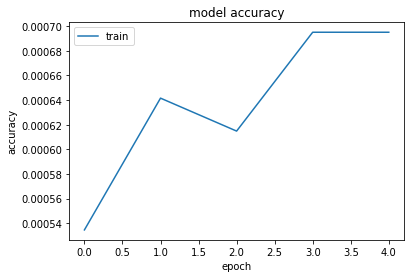

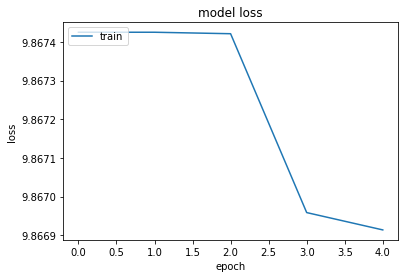

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model_results.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_results.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
import os
import gensim
# PERFORM DOC2VEc
# Take our preprocessed descrip, values and yield them the way it expects
def doc2_vec_preprocess(x,y):
    for i in range(len(X)):
      yield gensim.models.doc2vec.TaggedDocument(X[i], Y[i]) # Yield the tokens and their lable
train_ = list(doc2_vec_preprocess(descrips, labels)) # We want the untokenized values for now
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_)


UFuncTypeError: ignored

In [ ]:
print(train_[:2])


[TaggedDocument(words=array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 